In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import DatasetFolder
from torchvision import models
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np
import pandas as pd

#### Base Models

In [ ]:
# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim * 2)  # 产生均值和方差
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # 输出像素值在0到1之间
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# 超参数
input_dim = 784  # 假设图像是28x28像素，展平为784维向量
hidden_dim = 400
z_dim = 20  # 潜在空间的维度
learning_rate = 0.001
batch_size = 128
epochs = 10

# 加载数据集
# 假设你已经有了一个包含电子显微镜图像的Tensor数据集
images = ...  # 你的图像数据，形状为[num_samples, 784]
labels = ...  # 你的标签数据，如果不需要可以忽略
dataset = TensorDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化模型和优化器
vae = VAE(input_dim, hidden_dim, z_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(epochs):
    for data in dataloader:
        # 获取数据并移动到GPU（如果有）
        x = data[0]  # 假设data[0]是图像数据
        x = x.view(-1, input_dim)  # 展平图像

        # 重置梯度
        optimizer.zero_grad()

        # 前向传播
        reconstructed, mu, logvar = vae(x)

        # 计算损失函数
        # 重构损失
        recon_loss = nn.functional.mse_loss(reconstructed, x.view(-1, input_dim), reduction='sum')
        # KL散度损失
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss

        # 反向传播和优化
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# 保存模型
torch.save(vae.state_dict(), 'vae_model.pth')

# 使用模型进行图像重构
# 假设你有一个要重构的图像
# image_to_reconstruct = ...  # 你的图像数据，形状为[1, 784]
# reconstructed_image, _, _ = vae(image_to_reconstruct)
# reconstructed_image = reconstructed_image.view(28, 28)  # 将重构的图像恢复为28x28的形状
# 可以将重构的图像保存为图片或显示出来

In [ ]:
#用nn.squential重写模型结构，更加简洁
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        
        # 解码器部分
        self.decoder_fc = nn.Linear(20, 400)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_fc(z)
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 初始化模型
model = VAE()

# 打印模型结构
print(model)


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  (decoder_fc): Linear(in_features=20, out_features=400, bias=True)
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=400, out_features=784, bias=True)
    (2): Sigmoid()
  )
)


In [ ]:
model = VAE()

for name, layer in model.named_children():
    if hasattr(layer, 'weight'):
        print(f"{name}: {layer.weight.shape}")
    else:
        print(f"{name} is a non-linear operation or does not have weights")


encoder is a non-linear operation or does not have weights
fc_mu: torch.Size([20, 400])
fc_logvar: torch.Size([20, 400])
decoder_fc: torch.Size([400, 20])
decoder is a non-linear operation or does not have weights


#### Dataset Preparation

In [33]:
# 定义额外的转换
transform_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((400, 400), scale=(0.5, 0.9), ratio=(1,1), interpolation=2),
    # transforms.ToTensor()
])

# 设置图片文件夹路径和保存路径
image_folder_path = '2-Data/2-SEM/X5000/Train'
save_folder_path = '2-Data/2-SEM/X5000/AugmentationL/Train'

# 确保保存路径存在
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

# 遍历文件夹中的所有图片
for filename in os.listdir(image_folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff','.tif')):
        # 构建完整的文件路径
        image_path = os.path.join(image_folder_path, filename)

        name_without_extension = filename.split('.')[0]
        
        # 打开图片
        image = Image.open(image_path)
        #裁剪成（1500，1000）
        cropped_image = image.crop((0, 0, 1500, 1000))

        # 图片尺寸
        image_width, image_height = image.size

        # 裁剪尺寸
        crop_width, crop_height = 500, 500

        # 计算裁剪的数量
        num_crops_width = image_width // crop_width
        num_crops_height = image_height // crop_height
        repeats = 10

        # 裁剪图片并保存
        for i in range(num_crops_height):
            for j in range(num_crops_width):
                # 计算裁剪区域的左上角坐标
                left = j * crop_width
                upper = i * crop_height
                # 计算裁剪区域的右下角坐标
                right = left + crop_width
                lower = upper + crop_height
                # 裁剪图片
                crop = image.crop((left, upper, right, lower))

                for k in range(repeats):
                    #随机翻转图片
                    transformed_crop = transform_pipeline(crop)

                    # transformed_image = transforms.functional.to_pil_image(crop)
                    filename = f'{name_without_extension}-{i}-{j}-{k}.jpg'
                    save_path = os.path.join(save_folder_path, filename)
                    transformed_crop.save(save_path)
                # plt.show(crop)


In [ ]:
# # 定义转换管道
# def custom_transforms(image):
#     # 裁剪图片以保留[:1000, :1500]的部分
#     image = image.crop((0, 0, 1500, 1000))
#     # 裁剪成16张250x250大小的图片
#     crops = [image.crop((i*250, j*250, (i+1)*250, (j+1)*250)) for i in range(4) for j in range(4)]
#     # 随机水平或垂直翻转，并转换为tensor
#     transformed_crops = []
#     for crop in crops:
#         if torch.rand(1).item() > 0.5:
#             crop = transforms.functional.hflip(crop)
#         if torch.rand(1).item() > 0.5:
#             crop = transforms.functional.vflip(crop)
#         transformed_crops.append(transforms.functional.to_tensor(crop))
#     return transformed_crops

# # 创建自定义DatasetFolder类
# class CustomDatasetFolder(DatasetFolder):
#     def __init__(self, root, loader, extensions=None, transform=None, target_transform=None):
#         super(CustomDatasetFolder, self).__init__(root, loader, extensions, transform=transform, target_transform=target_transform)

#     def __getitem__(self, index):
#         path, target = self.samples[index]
#         sample = self.loader(path)
#         if self.transform is not None:
#             sample = self.transform(sample)
#         if self.target_transform is not None:
#             target = self.target_transform(target)
#         return sample, target

# # 使用自定义转换
# def custom_loader(path):
#     return Image.open(path).convert('RGB')

# # 创建数据集
# dataset = CustomDatasetFolder(
#     root=r'2-Data/2-SEM/X5000',  # 替换为你的图片文件夹路径
#     loader=custom_loader,
#     extensions=('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'),
#     transform=transforms.Compose([transforms.Lambda(lambda img: custom_transforms(img))])
# )

# # 创建DataLoader
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=32)


#### Practical Models

In [2]:
# 数据准备
transform = transforms.Compose([
#     transforms.CenterCrop(size=(500,500)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
# #    transforms.RandomRotation(degrees=180, expand=True, center=None),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])

dataset = datasets.ImageFolder(root=r'2-Data/2-SEM/X5000/Augmentation', transform=transform)


In [2]:
#定义VAE（卷积层）
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # 示例中假设输入是单通道图像
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512, 64)  # 假设最终的特征图大小为 25x25x128
        self.fc_logvar = nn.Linear(512, 64)

        # 解码器
        self.decoder_fc1 = nn.Linear(64, 512)
        self.decoder_fc2 = nn.Linear(512, 128 * 16 * 16)
        self.relu = nn.ReLU()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.decoder_fc1(z))
        h = self.relu(self.decoder_fc2(h))
        h = h.view(-1, 128, 16, 16)  # 重塑张量以匹配解码器的输入维度
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

In [5]:
convae = ConvVAE()
X = torch.rand(size=(256, 3, 256, 256), dtype=torch.float32)
#X = X.to('cuda')
for layer in convae.encoder:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)
X = torch.rand(size=(256,128,25,25), dtype=torch.float32)
#X = X.to('cuda')
for layer in convae.decoder:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([256, 16, 128, 128])
ReLU output shape: 	 torch.Size([256, 16, 128, 128])
Conv2d output shape: 	 torch.Size([256, 32, 64, 64])
ReLU output shape: 	 torch.Size([256, 32, 64, 64])
Conv2d output shape: 	 torch.Size([256, 64, 32, 32])
ReLU output shape: 	 torch.Size([256, 64, 32, 32])
Conv2d output shape: 	 torch.Size([256, 128, 16, 16])
ReLU output shape: 	 torch.Size([256, 128, 16, 16])
Flatten output shape: 	 torch.Size([256, 32768])
Linear output shape: 	 torch.Size([256, 512])
ReLU output shape: 	 torch.Size([256, 512])
ConvTranspose2d output shape: 	 torch.Size([256, 64, 50, 50])
ReLU output shape: 	 torch.Size([256, 64, 50, 50])
ConvTranspose2d output shape: 	 torch.Size([256, 32, 100, 100])
ReLU output shape: 	 torch.Size([256, 32, 100, 100])
ConvTranspose2d output shape: 	 torch.Size([256, 16, 200, 200])
ReLU output shape: 	 torch.Size([256, 16, 200, 200])
ConvTranspose2d output shape: 	 torch.Size([256, 3, 400, 400])
Sigmoid output shape: 	 torch

In [6]:
#定义损失函数
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')

    # KL散度损失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [ ]:
from torch.utils.tensorboard import SummaryWriter

# 初始化SummaryWriter
writer = SummaryWriter('runs/ConvVAE-2')
#训练循环
def train(model, num_epochs,dataloader, device, optimizer):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        gradient_norms = [] 
        for data in dataloader:
            #print (data.shape)
            data = data[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            #print(recon_batch.shape)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            #print(loss)

            # 计算并记录梯度范数
            for name, param in model.named_parameters():
                if param.grad is not None:
                    grad_norm = torch.norm(param.grad).item()
                    gradient_norms.append(grad_norm)
                    writer.add_scalar(f'Gradients/{name}_grad_norm', grad_norm, epoch)

        # 记录每个epoch的平均损失
        epoch_loss /= len(dataloader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        # 记录模型参数的梯度
        for name, param in model.named_parameters():
            writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

        
        # 记录所有参数的平均梯度范数
        if gradient_norms:
            avg_gradient_norm = np.mean(gradient_norms)
            writer.add_scalar('Gradients/avg_grad_norm', avg_gradient_norm, epoch)


    # 关闭SummaryWriter
    writer.close()


# 训练模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ConvVAE().to(device)
learning_rate = 5e-4
batch_size = 512
epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
train(model, epochs, dataloader, device, optimizer)


#### 图像输出

In [3]:
def print_image(data,model,num_pic,device):
    fig = plt.figure(figsize=(10,5*num_pic))
    for i in range (num_pic):
        image_raw = data[i][0]
        # print('raw_image:',image_raw.shape,image_raw)
        image_init = image_raw.squeeze(0)
        image_show = torch.sum(image_init,0)
        image_show = image_show / image_init.shape[0]
        a = fig.add_subplot(num_pic, 2, 2*i+1)
        # print('raw_image:',image_show.shape,image_show)
        plt.imshow(image_show.detach().cpu().numpy(),cmap='gray')
        image_raw = image_raw.to(device)
        #print(type(image_raw))
        model.eval()
        model.to(device)
        image,_,_ = model(image_raw.unsqueeze(0).float())
        #print(image.shape)
        image = image.squeeze()
        image_ = torch.sum(image,0)
        image_ = image_ / image.shape[0]
        # print(image)
        # image_ = image
        image_ = image_.detach().cpu().numpy()
        # print('restored_image:',image_.shape,image_)
        a = fig.add_subplot(num_pic, 2, 2*i+2)
        plt.imshow(image_,cmap='gray')

In [7]:
# 创建模型实例
model = ConvVAE()

# 指定保存的模型权重文件的路径
path_to_saved_model = r'./modelsL3e-4/model_epoch_5500.pth'

# 加载状态字典
state_dict = torch.load(path_to_saved_model)

# 将状态字典加载到模型中
model.load_state_dict(state_dict)

# 确保模型处于正确的设备上
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model.to(device)

# 现在模型已经加载了保存的权重，可以用于推理或继续训练


/tmp/ipykernel_507432/1417284581.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_to_saved_model)


RuntimeError: Error(s) in loading state_dict for ConvVAE:
	Missing key(s) in state_dict: "encoder.9.weight", "encoder.9.bias". 
	Unexpected key(s) in state_dict: "encoder.11.weight", "encoder.11.bias", "encoder.8.weight", "encoder.8.bias", "decoder.8.weight", "decoder.8.bias". 
	size mismatch for fc_mu.weight: copying a param with shape torch.Size([64, 2048]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for fc_logvar.weight: copying a param with shape torch.Size([64, 2048]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for decoder_fc1.weight: copying a param with shape torch.Size([2048, 64]) from checkpoint, the shape in current model is torch.Size([512, 64]).
	size mismatch for decoder_fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder_fc2.weight: copying a param with shape torch.Size([65536, 2048]) from checkpoint, the shape in current model is torch.Size([32768, 512]).
	size mismatch for decoder_fc2.bias: copying a param with shape torch.Size([65536]) from checkpoint, the shape in current model is torch.Size([32768]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([32, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 3, 3, 3]).
	size mismatch for decoder.6.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([3]).

In [5]:
# 数据准备
transform = transforms.Compose([
#     transforms.CenterCrop(size=(500,500)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
# #    transforms.RandomRotation(degrees=180, expand=True, center=None),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])

test_dataset = datasets.ImageFolder(root=r'2-Data/2-SEM/X5000/AugmentationL', transform=transform)


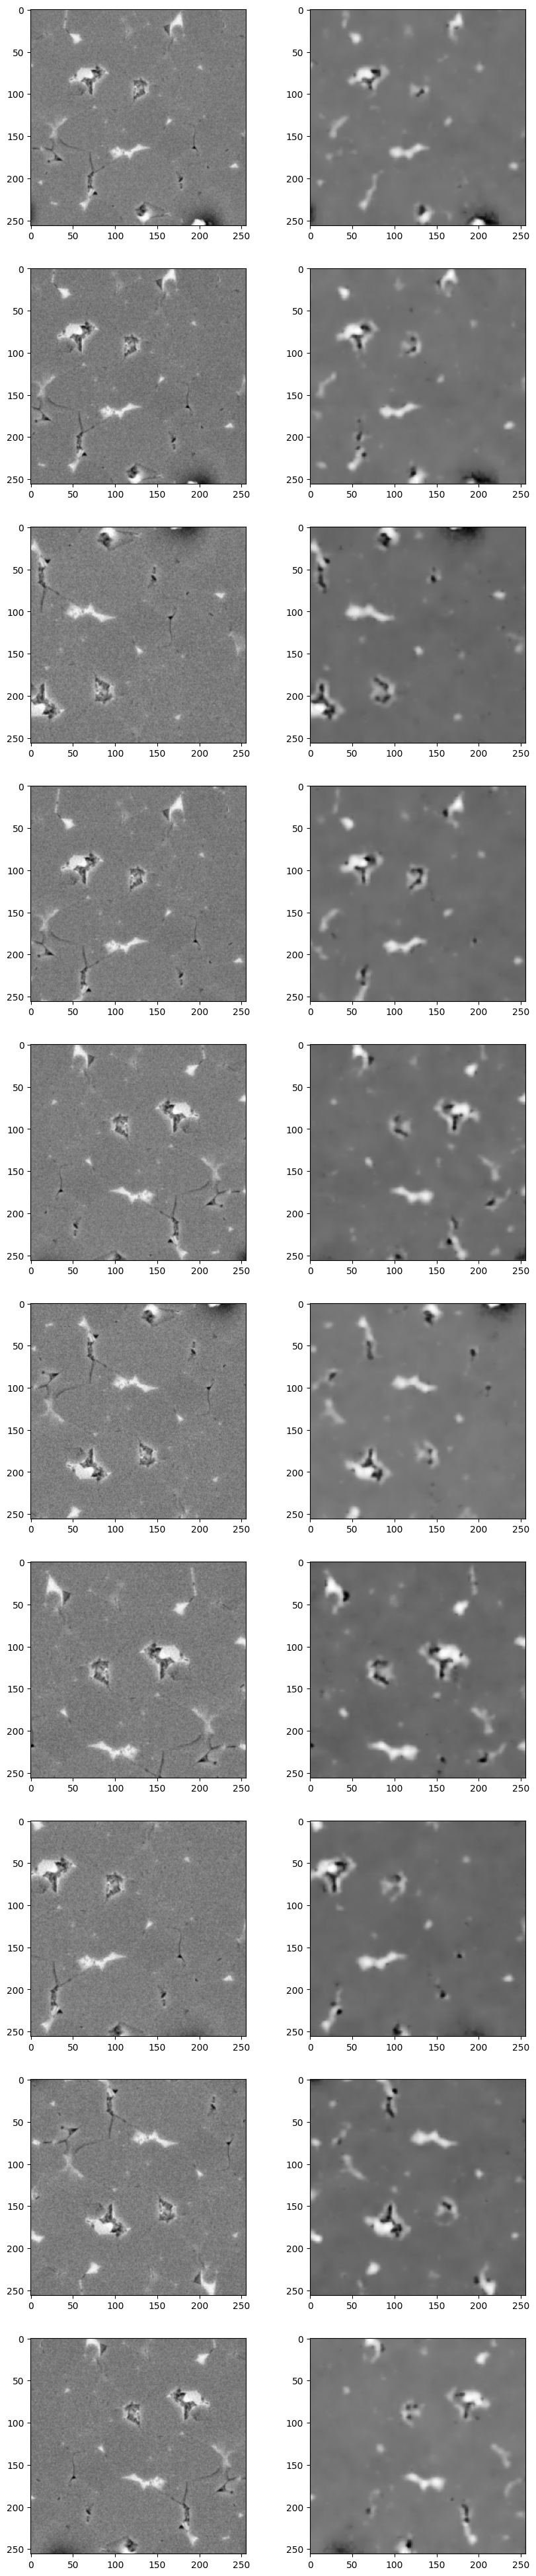

In [6]:
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
print_image(dataloader.dataset,model,10,device)

In [7]:
image_path= r'./2-Data/2-SEM/X5000/Train/1-1x5000.tif' 
image = Image.open(image_path)
print(image.size)

(1536, 1103)


In [8]:
def print_single_image(img_path,model,num_pic):
    fig = plt.figure(figsize=(10,45))
    for i in range (num_pic):
        image_raw = Image.open(img_path)
        # print('raw_image:',image_raw.shape,image_raw)
        image_show = torch.sum(image_raw,0)
        image_show = image_show / image_raw.shape[0]
        a = fig.add_subplot(num_pic, 2, 2*i+1)
        # print('raw_image:',image_show.shape,image_show)
        plt.imshow(image_show.detach().cpu().numpy(),cmap='gray')
        image_raw = image_raw.to('cuda')
        #print(type(image_raw))
        model.eval()
        model.to('cuda')
        image,_,_ = model(image_raw.unsqueeze(0).float())
        #print(image.shape)
        image = image.squeeze()
        image_ = torch.sum(image,0)
        image_ = image_ / image.shape[0]
        # print(image)
        # image_ = image
        image_ = image_.detach().cpu().numpy()
        # print('restored_image:',image_.shape,image_)
        a = fig.add_subplot(num_pic, 2, 2*i+2)
        plt.imshow(image_,cmap='gray')

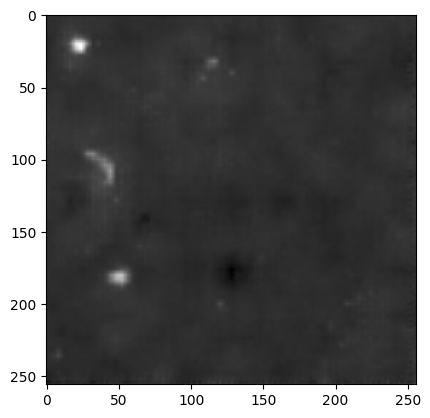

In [18]:
# 假设你有一个编码后的隐向量 z
z = torch.randn(1, 64)  # 假设 z 是一个 16x16 的随机张量

# 确保模型处于正确的设备上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 单独调用解码器
with torch.no_grad():  # 确保不会计算梯度
    decoded_output = model.decode(z.to(device))


image = decoded_output.squeeze()
image_ = torch.sum(image,0)
image_ = image_ / image.shape[0]
# print(image)
# image_ = image
image_ = image_.detach().cpu().numpy()
# print('restored_image:',image_.shape,image_)
plt.imshow(image_,cmap='gray')
# decoded_output 就是解码器的输出
